<h1> Predicting airline delays with Spark and ML-Lib using pySpark </h1>
<br>
Adapted from http://nbviewer.ipython.org/github/ofermend/IPython-notebooks/blob/master/blog-part-2.ipynb

<h3>Pre-processing with PySpark</h3>

In [1]:
import os.path

AIRPORT = 'ORD'

base_dir = os.path.join('data')
# http://stat-computing.org/dataexpo/2009/the-data.html
input_path_2007 = os.path.join('flights', '2007.csv')
input_path_2008 = os.path.join('flights', '2008.csv')
# http://www.ncdc.noaa.gov/cdo-web/datasets/
input_path_weather = os.path.join('flights', AIRPORT + '.csv')

file_name_2007 = os.path.join(base_dir, input_path_2007)
file_name_2008 = os.path.join(base_dir, input_path_2008)
file_name_weather = os.path.join(base_dir, input_path_weather)

raw_data_2007 = sc.textFile(file_name_2007)
raw_data_2008 = sc.textFile(file_name_2008)
weather_data = sc.textFile(file_name_weather)

header = raw_data_2007.take(1) 

filtered_data_2007 = (raw_data_2007
                        # filter on Airport
                        .filter(lambda line: ',' + AIRPORT + ',' in line)
                        # filter out cancelled flights
                        .filter(lambda line: ',,' in line)
                        .filter(lambda line: 'Year' not in line))
filtered_data_2008 = (raw_data_2008
                        # filter on Airport
                        .filter(lambda line: ',' + AIRPORT + ',' in line)
                        # filter out cancelled flights
                        .filter(lambda line: ',,' in line)
                        .filter(lambda line: 'Year' not in line))

# CRS = Computer Reservation System
# scheduled time as opposed to the actual time
print header
print filtered_data_2007.take(1)
print filtered_data_2008.take(1)

[u'Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay']
[u'2007,1,25,4,1052,1100,1359,1414,XE,1202,N12167,127,134,105,-15,-8,ORD,EWR,719,5,17,0,,0,0,0,0,0,0']
[u'2008,1,8,2,1711,1600,2031,1945,XE,1226,N14953,140,165,106,46,71,ORD,EWR,719,8,26,0,,0,0,0,2,0,44']


In [2]:
holidays = ['01/01/2007', '01/15/2007', '02/19/2007', '05/28/2007', '06/07/2007', '07/04/2007',
      '09/03/2007', '10/08/2007' ,'11/11/2007', '11/22/2007', '12/25/2007',
      '01/01/2008', '01/21/2008', '02/18/2008', '05/22/2008', '05/26/2008', '07/04/2008',
      '09/01/2008', '10/13/2008' ,'11/11/2008', '11/27/2008', '12/25/2008']

In [3]:
import datetime
import numpy as np
from pyspark.mllib.regression import LabeledPoint

def make_weather_dict():
    weather_dict = {}
    weather_lines = weather_data.collect()
    for line in weather_lines:
        all_vals = line.split(',')
        # key: date / values: precipitation, snow, max temp, min temp, average wind
        weather_dict[all_vals[2]] = [all_vals[3], all_vals[4], all_vals[5], all_vals[6], all_vals[7]]
    
    return weather_dict

def days_from_nearest_holiday(year, month, day):
    diffs = []
    sample_date = datetime.date(year, month, day)
    for holiday in holidays:
        dt = datetime.datetime.strptime(holiday, '%m/%d/%Y').date()
        td = dt - sample_date
        diffs.append(abs(td.days))

    return min(diffs) * 1.0
    
def make_labeled_point(flight):
    try:
        wd = weather_dict.value
        flight_data = flight.split(',')
        date_string = str(flight_data[0]) + str(flight_data[1]).zfill(2) + str(flight_data[2]).zfill(2)
        weather_data = wd[date_string]
        features = []
        lbl = 0.0
        if float(flight_data[15]) >= 15.0:
            lbl = 1.0
        features.append(float(flight_data[1]))         # Month
        features.append(float(flight_data[2]))         # DayofMonth
        features.append(float(flight_data[3]))         # DayOfWeek
        features.append(float(flight_data[5]) / 100)   # CRSDepTime
        features.append(days_from_nearest_holiday(int(flight_data[0]), int(flight_data[1]), int(flight_data[2]))) 
        features.append(float(weather_data[0]))        # precipitation
        features.append(float(weather_data[1]))        # snow (tenths of mm)
        features.append(float(weather_data[1]) / 10.0) # max temp (tenths of degrees C)
        features.append(float(weather_data[2]) / 10.0) # min temp (tenths of degrees C)
        features.append(float(weather_data[3]))        # average wind

        return (LabeledPoint(lbl, np.array(features)))
    except:
        return (LabeledPoint(0.0, [0.0 for i in range(10)]))

In [4]:
weather_dict = sc.broadcast(make_weather_dict())

train_data = filtered_data_2007.map(lambda line: make_labeled_point(line))
train_data.cache()
test_data = filtered_data_2008.map(lambda line: make_labeled_point(line))
test_data.cache()

print train_data.take(1)
print test_data.take(1)

[LabeledPoint(0.0, [1.0,25.0,4.0,11.0,10.0,0.0,0.0,0.0,-4.4,-94.0])]
[LabeledPoint(1.0, [1.0,8.0,2.0,16.0,7.0,168.0,0.0,0.0,13.3,28.0])]


<h3>Delay distribution in percent</h3>

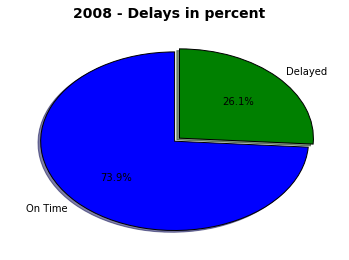

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

total = test_data.count()
late = test_data.filter(lambda lp: lp.label == 1.0).count()
labels = ['On Time', 'Delayed']
fracs = [total - late, late]
explode=(0, 0.05)

fig = plt.figure()
fig.suptitle('2008 - Delays in percent', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
ax.pie(fracs, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
pass

<h3>Delay distribution by month</h3>

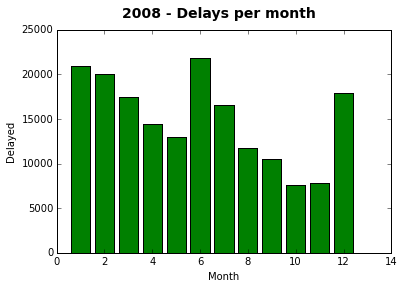

In [6]:
x_axis = [i + 1 for i in range(12)]
y_axis = (test_data.filter(lambda lp: lp.label == 1.0)
                   .map(lambda lp: (lp.features[0], 1))
                   .reduceByKey(lambda x, y: x + y)
                   .map(lambda tup: tup[1])
                   .collect())

fig = plt.figure()
fig.suptitle('2008 - Delays per month', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
ax.set_xlabel('Month')
ax.set_ylabel('Delayed')
ax.bar(x_axis, y_axis, color='g', align='center')
pass

<h3>Modeling with Spark and ML-Lib</h3>

In [7]:
def rescale(feat):
    m = feat.mean()
    s = np.std(feat)
    r = []
    for x in feat:
        r.append((x - m) / s)

    return np.array(r)

scaled_train_data = train_data.map(lambda lp: LabeledPoint(lp.label, rescale(lp.features)))
scaled_train_data.cache()

scaled_test_data = test_data.map(lambda lp: LabeledPoint(lp.label, rescale(lp.features)))
scaled_test_data.cache()

print scaled_train_data.take(1)
print scaled_test_data.take(1)

[LabeledPoint(0.0, [0.18629212918,0.965213923662,0.28365735349,0.510842876881,0.478387802111,0.15383705441,0.15383705441,0.15383705441,0.0110347254218,-2.89693997398])]
[LabeledPoint(1.0, [-0.479840062435,-0.335867476192,-0.459272550115,-0.171327377629,-0.356434988513,2.95493449507,-0.500407574756,-0.500407574756,-0.226859660894,0.0754827702159])]


In [8]:
def eval_metrics(lbl_pred):
    tp = float(lbl_pred.filter(lambda lp: lp[0]==1.0 and lp[1]==1.0).count())
    tn = float(lbl_pred.filter(lambda lp: lp[0]==0.0 and lp[1]==0.0).count())
    fp = float(lbl_pred.filter(lambda lp: lp[0]==1.0 and lp[1]==0.0).count())
    fn = float(lbl_pred.filter(lambda lp: lp[0]==0.0 and lp[1]==1.0).count())
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F_measure = 2 * precision * recall / (precision + recall)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    return([tp, tn, fp, fn], [precision, recall, F_measure, accuracy])

In [9]:
from pyspark.mllib.classification import LogisticRegressionWithSGD

model_lr = LogisticRegressionWithSGD.train(scaled_train_data, iterations=100)
labels_and_predictions = scaled_test_data.map(lambda lp: (model_lr.predict(lp.features), lp.label))
metrics = eval_metrics(labels_and_predictions)

print('Precision : %.2f' % round(metrics[1][0], 2))
print('Recall : %.2f' % round(metrics[1][1], 2))
print('F1 : %.2f' % round(metrics[1][2], 2))
print('Accuracy : %.2f' % round(metrics[1][3], 2))

Precision : 0.42
Recall : 0.37
F1 : 0.39
Accuracy : 0.70


In [10]:
from pyspark.mllib.classification import SVMWithSGD

model_svm = SVMWithSGD.train(scaled_train_data, iterations=100, step=1.0, regParam=0.01)
labels_and_predictions = scaled_test_data.map(lambda lp: (model_svm.predict(lp.features), lp.label))
metrics = eval_metrics(labels_and_predictions)

print('Precision : %.2f' % round(metrics[1][0], 2))
print('Recall : %.2f' % round(metrics[1][1], 2))
print('F1 : %.2f' % round(metrics[1][2], 2))
print('Accuracy : %.2f' % round(metrics[1][3], 2))

Precision : 0.40
Recall : 0.35
F1 : 0.37
Accuracy : 0.70


In [11]:
from pyspark.mllib.classification import NaiveBayes

# Naive Bayes expects positive 
# features, so we square them
def square(feat):
    r = []
    for x in feat:
        r.append(x ** 2)

    return np.array(r)

squared_train_data = train_data.map(lambda lp: LabeledPoint(lp.label, square(lp.features)))
squared_test_data = test_data.map(lambda lp: LabeledPoint(lp.label, square(lp.features)))

model_nb = NaiveBayes.train(squared_train_data)
labels_and_predictions = squared_test_data.map(lambda lp: (model_nb.predict(lp.features), lp.label))
metrics = eval_metrics(labels_and_predictions)

print('Precision : %.2f' % round(metrics[1][0], 2))
print('Recall : %.2f' % round(metrics[1][1], 2))
print('F1 : %.2f' % round(metrics[1][2], 2))
print('Accuracy : %.2f' % round(metrics[1][3], 2))

Precision : 0.44
Recall : 0.27
F1 : 0.33
Accuracy : 0.72
